Дано:

Данные со следующей структурой записываются для каждого пользователя, совершившего покупки, каждый день для каждой даты есть своя папка, внутри неё – папки для каждого пользователя внутри каждой папки есть файл data.csv, где и хранятся данные Схематично выглядит так:

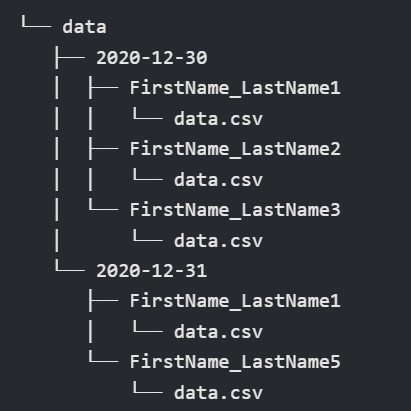

Например, 30 декабря три покупателя сделали покупки, 31 – два (папки 2020-12-30 и 2020-12-31 соответственно). Поскольку клиент FirstName_LastName1 купил товары в оба дня, для него имеется папка в папке для каждой из дат. Для других клиентов – по одной.

Задачи:

1. Необходимо собрать все данные из папки data в один датафрэйм, имеющий следующие столбцы: колонки из самих файлов (product_id, quantity), а также имя пользователя (name), и дата этих покупок (date, соответствует названию папки, где лежит папка с пользователем).

2. Выяснить, какие пользователи купили больше всего товаров. 

3. Найти топ-10 товаров по числу проданных единиц за всё время и построить барплот. 

4. Визуализация продаж по дням.

5. Подсчитать пользователей, которые приобрели какой-либо товар повторно (более 1 раза). Повтором будем считаться покупка товара с одинаковым product_id, совершенная в разные дни. 

In [1]:
# импортируем необходимые библиотеки
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Собираем данные в один датафрэймю

In [2]:
# получим дерево вложенных папок и файлов в виде кортежей
tree = os.walk('/home/jupyter-v.panshina-15/shared/homeworks/python_ds_miniprojects/4/data/')

In [3]:
path = '/home/jupyter-v.panshina-15/shared/homeworks/python_ds_miniprojects/4/data/'

In [4]:
# соберем ДФ из файлов 
df = pd.DataFrame(columns = ['product_id', 'quantity', 'name', 'date'])

for path,_,file in tree:
    if len(file) == 0:
        continue 
        
    tdf = pd.read_csv(path + '/' + file[0], sep = ',', encoding = 'windows-1251', header = 0)
    
    
tmplist = path.split('/')
    
tdf['name'] = tmplist[-1]
tdf['date'] = tmplist[-2]

df = pd.concat([df, tdf], axis = 'index')

df = df.drop(columns = 'Unnamed: 0')
df = df.reset_index(drop = True)
df['date'] = pd.to_datetime(df.date, yearfirst = True)

In [5]:
df

,product_id,quantity,name,date
0,95,2,Vasiliy_Ivanov,2020-12-07
1,83,3,Vasiliy_Ivanov,2020-12-07
2,64,1,Vasiliy_Ivanov,2020-12-07


In [6]:
tdf

,Unnamed: 0,product_id,quantity,name,date
0,0,95,2,Vasiliy_Ivanov,2020-12-07
1,1,83,3,Vasiliy_Ivanov,2020-12-07
2,2,64,1,Vasiliy_Ivanov,2020-12-07


In [7]:
path = '/home/jupyter-v.panshina-15/shared/homeworks/python_ds_miniprojects/4/data/'

In [8]:
# Создаем общий ДФ
df = pd.DataFrame()

# читаем данные и добавляем в ДФ
for current_path, dirs, files in os.walk(path):
    for file in files:
        data_path = f'{current_path}/{file}'
        
         # читаем данные
        temp_df = pd.read_csv(data_path)
        
        # вычленяем из названия папок данные
        path_parts = current_path.split('/')
        name = path_parts[-1]
        date = path_parts[-2]
        
        # добавляем колонки
        temp_df['name'] = name
        temp_df['date'] = date
        
        # объеденяем два ДатаФрэйма
        df = pd.concat((df, temp_df))
        
        

In [9]:
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,product_id,quantity,name,date
0,27,4,Petr_Ivanov,2020-12-05
1,89,1,Petr_Ivanov,2020-12-05
2,33,2,Petr_Ivanov,2020-12-05
3,8,3,Petr_Ivanov,2020-12-05
4,16,1,Petr_Ivanov,2020-12-05


Выясним, какие пользователи купили больше всего товаров. 

In [10]:
# выведем топ-5 покупателей
df.groupby('name', as_index=False).agg({'quantity': 'sum'}).sort_values('quantity', ascending=False).head(5)

,name,quantity
3,Alexey_Smirnov,52
13,Petr_Smirnov,52
6,Anton_Smirnov,45
10,Petr_Fedorov,34
7,Kirill_Fedorov,28


Найдем топ-10 товаров по числу проданных единиц за всё время и построим барплот. 

In [11]:
product_quantity = df.groupby('product_id', as_index=False)['quantity']\
                     .sum().sort_values(by='quantity', ascending=False).head(10)

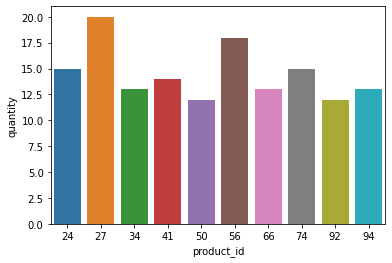

In [12]:
# строим барплот
sns.barplot(x='product_id', y='quantity', data=product_quantity)
plt.show()

Визуализируем продажи по дням.

In [13]:
sales_by_day=df.groupby('date', as_index=False).agg({'quantity': 'sum'})

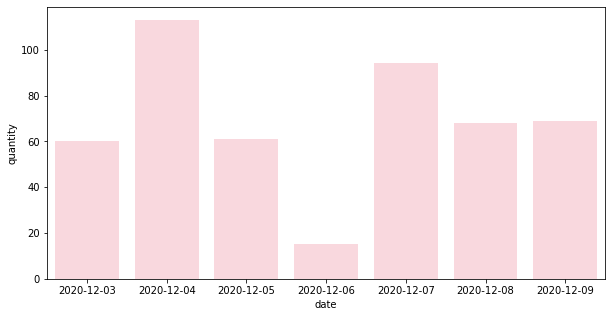

In [14]:
plt.figure(figsize=(10, 5))
sns.barplot(x=sales_by_day.date, y=sales_by_day.quantity, color='pink', alpha=0.7)
plt.show()

На графике мы видим, что:

- 08.12 и 09.12 было продано примерно одинаковое число товаров
- меньше всего товаров было приобретено 06.12
- максимальное число товаров было продано 04.12
- 04.12 было куплено почти в 2 раза больше товаров, чем в предыдущий день

Подсчитаем пользователей, которые приобрели какой-либо товар повторно (более 1 раза). 

In [15]:
df.groupby(['name', 'product_id'], as_index=False)\
  .agg({'date':'nunique'})\
  .rename(columns={'date':'quantity_purchases'})\
  .query('quantity_purchases>1')

,name,product_id,quantity_purchases
37,Anton_Ivanov,15,2
92,Petr_Fedorov,94,2


Всего два пользователя преобрели товар повторно.